# Import library

In [1]:
import time

import statistics 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import scikitplot as skplt

#confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


import graphviz
from sklearn.tree import export_graphviz

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Load dataset

In [3]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Adding player's rank on tennis player's profile

In [4]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181501 entries, 0 to 185763
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          181501 non-null  object 
 1   tourney_name        181501 non-null  object 
 2   surface             181354 non-null  object 
 3   draw_size           181501 non-null  float64
 4   tourney_level       181501 non-null  object 
 5   tourney_date        181501 non-null  object 
 6   match_num           181501 non-null  float64
 7   winner_id           181501 non-null  float64
 8   winner_entry        25298 non-null   object 
 9   winner_name         181501 non-null  object 
 10  winner_hand         181501 non-null  object 
 11  winner_ioc          181501 non-null  object 
 12  winner_age          178681 non-null  float64
 13  loser_id            181501 non-null  float64
 14  loser_entry         43307 non-null   object 
 15  loser_name          181501 non-nul

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')
print(player, '\n# of nan:', player['rank'].isna().sum())

                   name    rank
0         AARON ADDISON  1037.0
1         AARON ADDISON  1254.0
2         AARON ADDISON  1255.0
3         AARON ADDISON  1047.0
4         AARON ADDISON  1055.0
...                 ...     ...
257926  ZUZANA ZLOCHOVA   343.0
257927  ZUZANA ZLOCHOVA   335.0
257928  ZUZANA ZLOCHOVA   316.0
257929  ZUZANA ZLOCHOVA   318.0
257930  ZUZANA ZLOCHOVA   316.0

[257931 rows x 2 columns] 
# of nan: 7622


In [6]:
#osserviamo quanti giocatori hanno QUALCHE nan
nan_name = player[player['rank'].isna()]
nan_name['name'].nunique()

763

In [7]:
#prendiamo la media del rank e vediamo se sono rimasti nan (per quelli che avranno nan come rank vuol dire che nel db originale 
# non era presente nessun valore di rank per quel giocatore)
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2037.000000
mean      490.356406
std       327.419749
min         3.000000
25%       243.000000
50%       422.000000
75%       682.000000
max      1908.000000
Name: rank, dtype: float64

In [8]:
#stampo il numero di giocatori che non hanno nemmeno un valore associato al rank
player.isna().sum()

rank    35
dtype: int64

In [9]:
player['rank'].nunique()

947

In [10]:
#stampo il nome dei giocatori di cui non conosco il rank
player[player['rank'].isna()]

,rank
name,
ABIR EL FAHIMI,NaN
ALEX LAWSON,NaN
AMAL SULTANBEKOV,NaN
AMARNI BANKS,NaN
ANASTASIA IAMACHKINE,NaN
ANNA BOWTELL,NaN
BARBORA PALICOVA,NaN
BREANA STAMPFLI,NaN
CHARLOTTE KEMPENAERS POCZ,NaN


In [11]:
player.reset_index(inplace = True)
player

,name,rank
0,AARON ADDISON,1131.0
1,ABBIE MYERS,475.0
2,ABHINAV SANJEEV SHANMUGAM,1233.0
3,ABIGAIL TERE APISAH,422.0
4,ABIR EL FAHIMI,NaN
...,...,...
2067,ZIZOU BERGS,371.0
2068,ZOE HIVES,319.0
2069,ZOE KRUGER,750.0
2070,ZSOMBOR PIROS,454.0


In [12]:
#unisco le due tabelle
df = pd.merge(df, player, how='left', on='name')

df.describe()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.00000,2037.000000
mean,0.486609,100.942085,0.478162,23.541988,0.309913,1993.805502,179.104946,80.432832,6.716569,0.523839,871.927124,7.450516,43.113605,6.698571,6.355497,54.31431,490.356406
std,0.115073,78.005562,0.134808,26.280039,0.264866,5.063032,8.008870,16.122646,5.324856,0.146481,720.860044,3.444339,12.302156,4.583606,1.962237,19.24605,327.419749
min,0.133333,0.000000,0.000000,0.000000,0.000000,1977.000000,157.000000,55.472222,0.000000,0.037581,0.000000,0.000000,0.000000,0.070000,0.000000,0.91000,3.000000
25%,0.423077,28.000000,0.415466,0.000000,0.000000,1990.000000,173.000000,62.607850,2.400000,0.505333,230.000000,5.220000,40.770000,2.550000,5.390000,39.42750,243.000000
50%,0.500000,82.000000,0.500000,12.000000,0.375000,1994.000000,178.000000,82.359127,5.755000,0.580575,638.500000,6.950000,47.295000,6.155000,6.615000,64.30500,422.000000
75%,0.565673,170.000000,0.566866,45.000000,0.533333,1998.000000,185.705882,94.008066,9.840000,0.614162,1446.500000,9.172500,50.112500,10.312500,7.552500,69.80000,682.000000
max,0.845161,309.000000,1.000000,101.000000,1.000000,2006.000000,198.000000,145.073643,35.390000,0.949992,3834.000000,29.860000,94.180000,23.310000,17.890000,80.79000,1908.000000


## Transform categorical features into numerical ones

In [13]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [14]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [15]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   num_matches_2016-2019  2072 non-null   float64
 2   ratio_2016-2019        2072 non-null   float64
 3   num_matches_2020-2021  2072 non-null   float64
 4   ratio_2020-2021        2072 non-null   float64
 5   birth                  2072 non-null   float64
 6   ht                     2072 non-null   float64
 7   minutes                2072 non-null   float64
 8   perc_ace               2072 non-null   float64
 9   serv_won_tot_seve      2072 non-null   float64
 10  bpFaced                2072 non-null   float64
 11  perc_df                2072 non-null   float64
 12  perc_2ndwon            2072 non-null   float64
 13  perc_v_ace             2072 non-null   float64
 14  perc_v_df              2072 non-null   float64
 15  perc

### Write to csv before classification

In [17]:
df.to_csv('dataset/players_classification.csv')

## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli. Nel nostro caso ci siamo basati sul rank. 

Nota: questa non è una metrica efficace perchè il vero label del giocatore viene calcolato in base a diversi parametri come ad esempio il punteggio realizzato derivante dalla vincita dei vari tornei ma dato che esso risulta difficile stimarlo utilizzare le informazioni sui rank potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili per contraddistinguere i due tipi di giocatori, in paticolare consideriamo i giocatori più forti quelli che compaiono nei primi 25% del dataset in ordine di rank decrescente, mentre i rimanenti risultano di basso livello

In [18]:
df.sort_values(by=['rank'])

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank,hand_num,gender_num,ioc_num
1493,0.845161,229.0,0.829694,81.0,0.888889,1987.0,188.000000,118.034749,10.43,0.675834,1454.0,4.92,54.72,11.15,6.01,65.42,3.0,1,1,78
1782,0.754579,232.0,0.745690,41.0,0.804878,1991.0,168.000000,88.797710,4.19,0.590683,1808.0,5.50,48.38,4.38,7.17,58.06,3.0,1,0,71
1617,0.835616,235.0,0.842553,57.0,0.807018,1986.0,185.000000,122.658811,7.35,0.679608,1377.0,3.69,57.72,12.03,5.78,64.74,3.0,0,1,26
1672,0.828829,202.0,0.841584,20.0,0.700000,1981.0,185.000000,112.136728,17.50,0.712798,874.0,3.41,58.48,10.92,5.65,68.16,4.0,1,1,80
1021,0.699405,270.0,0.711111,66.0,0.651515,1992.0,184.000000,97.553718,15.94,0.618893,2185.0,7.84,45.59,7.41,8.34,63.85,7.0,1,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0.133333,15.0,0.133333,0.0,0.000000,1999.0,172.137193,97.307692,3.15,0.391993,159.0,9.15,36.12,2.83,5.98,54.02,NaN,2,0,49
1701,0.379310,8.0,0.375000,21.0,0.380952,2002.0,177.500000,61.904040,3.20,0.409342,305.0,12.49,31.81,0.08,0.49,5.00,NaN,2,0,27
1833,0.500000,16.0,0.500000,0.0,0.000000,1994.0,173.363636,59.750000,0.00,0.130994,72.0,5.81,13.16,1.44,2.89,11.19,NaN,2,0,29
1866,0.380952,21.0,0.380952,0.0,0.000000,1994.0,172.137193,71.658654,0.72,0.482784,139.0,10.25,43.84,1.65,8.06,25.41,NaN,2,0,52


In [19]:
# primo quartile (25%)
quantile_a = df['rank'].quantile(0.25)


In [20]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [21]:
#faccio un drop dei null perchè saranno quelli con cui poi andrò a stimarne il valore
df = df.drop(df[df['rank'].isna()].index)

In [22]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [23]:
class_names = ['high-level', 'low-level']

In [24]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.746686
0    0.253314
Name: labels, dtype: float64

### Prepare dataset (splitting)

In [25]:
del df['rank']

In [26]:
#use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
#of label in train and test set 
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

In [27]:
np.size(train_label)

1527

# Classification 

Abbiamo usato 9 metodi di classificazione diversi al fine di selezionare il migliore in particolare:

**Tree-based classifiers**
- Decision Tree

**Naive Bayes classifiers**
- Bayesian classifier

**Machine Learning classifiers**
- Neural Network

**Neighbors-based classifiers**
- KNN
- Radius-Neighbors 

**Support Vector Machine**
- SVM

**Rule based classifiers**
- Rule based

**Ensemble Method**
- AdaBoosting
- Random forest

# Function for print report, ROC, confusion matrix

In [28]:
def print_all(models, training , training_pred, test, test_pred, roc="yes"):
    #print all classification report
    print("TRAINING:\n",classification_report(train_label, training_pred, target_names=class_names))
    print("TEST:\n",classification_report(test_label, test_pred, target_names=class_names))
    
    #plot confusion matrix
    cm = confusion_matrix(test_label, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    #plot ROC
    if(roc=="yes"):
        test_pred_proba = models.predict_proba(test)
        skplt.metrics.plot_roc(test_label, test_pred_proba)

## Classfication with decision tree

In [29]:
#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image

### Grid Search

In [30]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    "class_weight":[None, {0: 0.65, 1: 0.25}]
    }


#define the grid search
dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, n_jobs=-1,
                            scoring=make_scorer(f1_score))

In [31]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 14, 'min_samples_split': 19, 'splitter': 'random'}


In [32]:
blind_pred_dt = dt_grid.predict(blindtest)

In [33]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [34]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png())


digraph Tree {
node [color="black", fontname="helvetica", shape=box, style="filled, rounded"];
edge [fontname="helvetica"];
0 [fillcolor="#7cbeee", label="X[1] <= 182.559\ngini = 0.378\nsamples = 1527\nvalue = [387, 1140]\nclass = 1"];
1 [fillcolor="#56abe9", label="X[1] <= 129.218\ngini = 0.223\nsamples = 1198\nvalue = [153, 1045]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#47a4e7", label="X[5] <= 1985.966\ngini = 0.127\nsamples = 953\nvalue = [65, 888]\nclass = 1"];
1 -> 2;
3 [fillcolor="#c4e2f7", label="X[1] <= 30.483\ngini = 0.485\nsamples = 63\nvalue = [26, 37]\nclass = 1"];
2 -> 3;
4 [fillcolor="#6ab6ec", label="gini = 0.32\nsamples = 20\nvalue = [4, 16]\nclass = 1"];
3 -> 4;
5 [fillcolor="#fef9f6", label="X[17] <= 0.12\ngini = 0.5\nsamples = 43\nvalue = [22, 21]\nclass = 0"];
3 -> 5;
6 [fillcolor="#fcf2eb", label="gini = 0.499\nsamples = 19\nvalue = [10, 9]\nclass = 0"];
5 -> 6;
7 [fillcolor="#ffffff", label="gini = 0.5\nsamples =

### Evaluation of the decision tree

TRAINING:
               precision    recall  f1-score   support

  high-level       0.88      0.81      0.84       387
   low-level       0.94      0.96      0.95      1140

    accuracy                           0.92      1527
   macro avg       0.91      0.89      0.90      1527
weighted avg       0.92      0.92      0.92      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.83      0.74      0.78       129
   low-level       0.91      0.95      0.93       381

    accuracy                           0.89       510
   macro avg       0.87      0.84      0.85       510
weighted avg       0.89      0.89      0.89       510



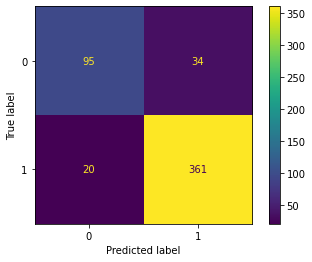

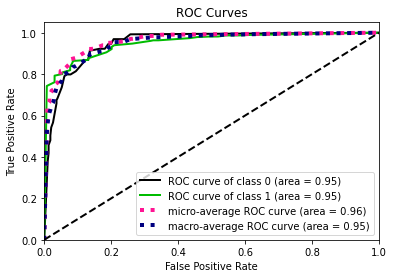

In [35]:
print_all(dt_grid,train_set,train_pred_dt,test_set,test_pred_dt)

## Bayesian classifier

In [36]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [37]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.66      0.91      0.77       387
   low-level       0.97      0.84      0.90      1140

    accuracy                           0.86      1527
   macro avg       0.81      0.88      0.83      1527
weighted avg       0.89      0.86      0.86      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.68      0.94      0.79       129
   low-level       0.98      0.85      0.91       381

    accuracy                           0.87       510
   macro avg       0.83      0.89      0.85       510
weighted avg       0.90      0.87      0.88       510



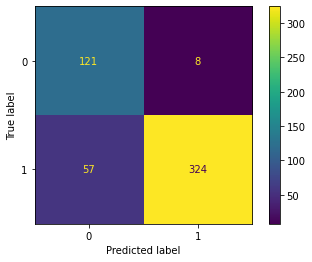

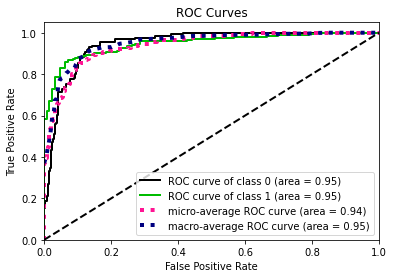

In [38]:
print_all(gnb,train_set,train_pred_gnb,test_set,test_pred_gnb)

## Neural Network

In [39]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Init Plugin
Init Graph Optimizer
Init Kernel


In [40]:
def create_model(n_neurons1, activation1, n_neurons2, activation2, optimizer, activation_out, loss): 
    # create model
    model = Sequential()
    model.add(Dense(n_neurons1, kernel_initializer='uniform', input_dim=19, activation=activation1)) 
    model.add(Dense(1,  kernel_initializer='uniform', activation=activation_out))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model

In [41]:
grid_param = {
    "n_neurons1":[20],
    "activation1":["relu"],
    "n_neurons2":[20],
    "activation2":["softmax"],
    "optimizer": ['adam'],
#     "activation_out":["softmax","relu","sigmoid"],
#    "dropout_rate" : [0.2],
    "activation_out":["linear"],
    "loss":["mean_squared_error"]
}

nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)
nn_grid = GridSearchCV(nn, param_grid=grid_param, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))


In [42]:
start = time.time()
best_model = nn_grid.fit(train_set, train_label)
print(nn_grid.best_params_)
train_pred_nn = nn_grid.predict(train_set)
test_pred_nn = nn_grid.predict(test_set)
print('Time taken for fit: {} sec\n'.format(time.time() - start))

Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Init Plugin
Init Plugin
Init Graph Optimizer
Init Graph Optimizer
Init Kernel
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1


2021-12-29 15:46:52.103959: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 15:46:52.104015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 15:46:52.104558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-29 15:46:52.104557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1


2021-12-29 15:46:52.337785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 15:46:52.338326: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-29 15:46:52.346587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 15:46:52.346708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-29 15:46:52.366546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been b

Epoch 1/150
12/42 [=======>......................] - ETA: 0s - loss: 5.0932 - accuracy: 0.546996

2021-12-29 15:46:52.879848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 15:46:52.880065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


42/42 [==============================] - 1s 15ms/step - loss: 2.0863 - accuracy: 0.5823


2021-12-29 15:46:53.377564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 15:46:53.377911: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-29 15:46:53.383836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 15:46:53.384222: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-29 15:46:53.531556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 1s 16ms/step - loss: 16.2101 - accuracy: 0.6587
Epoch 2/150
42/42 [==============================] - 1s 15ms/step - loss: 1.5153 - accuracy: 0.6243
Epoch 2/150
42/42 [==============================] - 1s 12ms/step - loss: 0.2845 - accuracy: 0.6504
Epoch 3/150
42/42 [==============================] - 1s 14ms/step - loss: 0.1610 - accuracy: 0.8121
Epoch 3/150
 5/42 [==>...........................] - ETA: 0s - loss: 0.1954 - accuracy: 0.6938

2021-12-29 15:46:53.967265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-29 15:46:54.051937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 1s 12ms/step - loss: 0.1480 - accuracy: 0.7837
Epoch 4/150
42/42 [==============================] - 1s 13ms/step - loss: 0.1398 - accuracy: 0.8069
Epoch 4/150
42/42 [==============================] - 0s 10ms/step - loss: 0.1128 - accuracy: 0.8653
Epoch 6/150
42/42 [==============================] - 0s 10ms/step - loss: 0.1315 - accuracy: 0.8091
Epoch 6/150
42/42 [==============================] - 1s 12ms/step - loss: 0.1135 - accuracy: 0.8458
Epoch 7/150
42/42 [==============================] - 0s 11ms/step - loss: 0.1350 - accuracy: 0.7987
Epoch 7/150
42/42 [==============================] - 0s 11ms/step - loss: 0.1087 - accuracy: 0.8690
Epoch 8/150
42/42 [==============================] - 0s 9ms/step - loss: 0.1104 - accuracy: 0.8593
Epoch 8/150
42/42 [==============================] - 4s 8ms/step - loss: 0.9628 - accuracy: 0.6385
Epoch 9/150
42/42 [==============================] - 1s 12ms/step - loss: 0.1047 - accuracy: 0.8825
Epoch 10/150
4

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 [==============================] - 1s 18ms/step - loss: 0.0726 - accuracy: 0.9184


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-29 15:49:16.815697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 1s 17ms/step - loss: 0.0735 - accuracy: 0.9147
Epoch 150/150
23/42 [===============>..............] - ETA: 0s - loss: 0.0702 - accuracy: 0.9117

2021-12-29 15:49:17.008979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


21/42 [==============>...............] - ETA: 0s - loss: 0.0701 - accuracy: 0.9152

2021-12-29 15:49:17.280483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


 1/42 [..............................] - ETA: 0s - loss: 0.0815 - accuracy: 0.9062

2021-12-29 15:49:17.699435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


17/42 [===========>..................] - ETA: 0s - loss: 0.0676 - accuracy: 0.9301

2021-12-29 15:49:18.033225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 1s 17ms/step - loss: 0.0688 - accuracy: 0.9132
Epoch 113/150
42/42 [==============================] - 1s 13ms/step - loss: 0.0752 - accuracy: 0.9140
Epoch 120/150
42/42 [==============================] - 0s 8ms/step - loss: 0.0685 - accuracy: 0.9094
Epoch 114/150
42/42 [==============================] - 0s 7ms/step - loss: 0.0761 - accuracy: 0.9065
Epoch 121/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.8997
Epoch 115/150
42/42 [==============================] - 0s 7ms/step - loss: 0.0772 - accuracy: 0.9095
Epoch 122/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0726 - accuracy: 0.9102
Epoch 116/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0707 - accuracy: 0.9094
Epoch 148/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0825 - accuracy: 0.8998
Epoch 123/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0668 - accuracy: 0.9169
Ep

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-29 15:49:20.018617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 0s 5ms/step - loss: 0.0713 - accuracy: 0.9109
Epoch 120/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0731 - accuracy: 0.9170
Epoch 127/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0737 - accuracy: 0.9140
Epoch 128/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0697 - accuracy: 0.9169
Epoch 122/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0719 - accuracy: 0.9170
Epoch 129/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0754 - accuracy: 0.9064
Epoch 123/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0907 - accuracy: 0.8901
Epoch 130/150
42/42 [==============================] - 0s 5ms/step - loss: 0.0829 - accuracy: 0.8968
Epoch 131/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0721 - accuracy: 0.9132
Epoch 125/150
42/42 [==============================] - 0s 6ms/step - loss: 0.0756 - accuracy: 0.8975
Epoc

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-29 15:49:25.761303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 0s 4ms/step - loss: 0.0785 - accuracy: 0.9027
Epoch 145/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0708 - accuracy: 0.9132
Epoch 146/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9064
Epoch 147/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0777 - accuracy: 0.9004
Epoch 148/150
42/42 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9132
Epoch 149/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0714 - accuracy: 0.9147
Epoch 150/150
42/42 [==============================] - 0s 4ms/step - loss: 0.0776 - accuracy: 0.9049


/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-29 15:49:26.801745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-29 15:49:26.899436: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 15:49:26.899846: I

Metal device set to: Apple M1


2021-12-29 15:49:27.306613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 15:49:27.307093: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-29 15:49:27.498556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/150
48/48 [==============================] - 2s 5ms/step - loss: 12.7005 - accuracy: 0.4126
Epoch 2/150
48/48 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.7773
Epoch 3/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1533 - accuracy: 0.8068
Epoch 4/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1406 - accuracy: 0.8193: 0s - loss: 0.1547 - accuracy: 0.
Epoch 5/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1319 - accuracy: 0.8232
Epoch 6/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.8330
Epoch 7/150
48/48 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.8487
Epoch 8/150
48/48 [==============================] - 0s 5ms/step - loss: 0.1108 - accuracy: 0.8592
Epoch 9/150
48/48 [==============================] - 0s 5ms/step - loss: 0.1098 - accuracy: 0.8585
Epoch 10/150
48/48 [==============================] - 0s 5ms/step - loss: 

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-29 15:50:00.917398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), a

### Accuracy

In [43]:
test=best_model.best_estimator_
history=test.fit(train_set, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.4)

Epoch 1/120
2/2 [==============================] - 0s 104ms/step - loss: 73.0387 - accuracy: 0.6921 - val_loss: 43.2376 - val_accuracy: 0.4108
Epoch 2/120
2/2 [==============================] - 0s 21ms/step - loss: 33.9414 - accuracy: 0.3810 - val_loss: 23.5472 - val_accuracy: 0.2520
Epoch 3/120
1/2 [==============>...............] - ETA: 0s - loss: 19.8815 - accuracy: 0.2400

2021-12-29 15:50:01.170461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-29 15:50:01.287984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 20ms/step - loss: 20.1986 - accuracy: 0.2413 - val_loss: 22.5724 - val_accuracy: 0.1817
Epoch 4/120
2/2 [==============================] - 0s 20ms/step - loss: 22.0396 - accuracy: 0.2041 - val_loss: 25.0992 - val_accuracy: 0.2046
Epoch 5/120
2/2 [==============================] - 0s 21ms/step - loss: 24.2387 - accuracy: 0.2183 - val_loss: 23.0570 - val_accuracy: 0.2046
Epoch 6/120
2/2 [==============================] - 0s 19ms/step - loss: 21.3351 - accuracy: 0.2282 - val_loss: 17.1669 - val_accuracy: 0.2095
Epoch 7/120
2/2 [==============================] - 0s 20ms/step - loss: 15.2363 - accuracy: 0.2172 - val_loss: 11.1031 - val_accuracy: 0.1931
Epoch 8/120
2/2 [==============================] - 0s 20ms/step - loss: 9.5545 - accuracy: 0.2052 - val_loss: 7.2804 - val_accuracy: 0.1964
Epoch 9/120
2/2 [==============================] - 0s 26ms/step - loss: 6.2362 - accuracy: 0.2347 - val_loss: 6.0328 - val_accuracy: 0.2782
Epoch 10/120
2/2 [====

### Print accuracy of best models

/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_43938/3007715566.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_43938/3007715566.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')


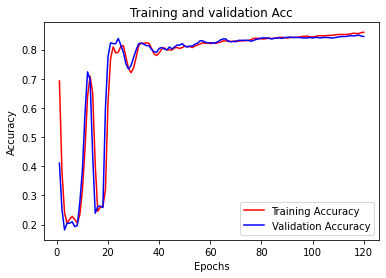

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Print accuracy of best models

/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_43938/2382457563.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
/var/folders/q3/n1kzrjss3rlcf4h0671f29640000gn/T/ipykernel_43938/2382457563.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')


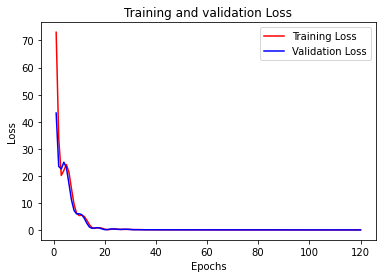

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.76      0.88      0.82       387
   low-level       0.96      0.91      0.93      1140

    accuracy                           0.90      1527
   macro avg       0.86      0.89      0.87      1527
weighted avg       0.91      0.90      0.90      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.74      0.85      0.79       129
   low-level       0.95      0.90      0.92       381

    accuracy                           0.89       510
   macro avg       0.84      0.88      0.86       510
weighted avg       0.89      0.89      0.89       510



2021-12-29 15:50:04.822590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


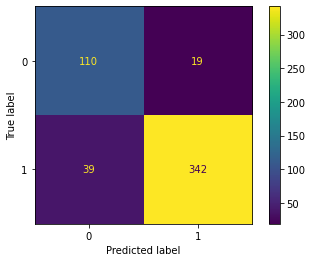

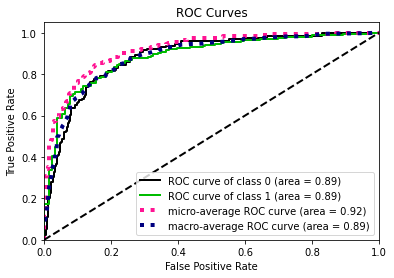

In [46]:
print_all(nn_grid,train_set,train_pred_nn,test_set,test_pred_nn)

## KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [48]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

k = math.sqrt(len(train_set))
k = round(k, 0)
k = int(k)
k = k - 10
k_range = []
for i in range(0,20):
    k_range.append(k)
    k = k + 1

In [49]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=8, scoring=make_scorer(f1_score))

In [50]:
knn_grid.fit(train_set_no_cat, train_label)

GridSearchCV(cv=8, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
                                         39, 40, 41, 42, 43, 44, 45, 46, 47,
                                         48],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score))

In [51]:
train_pred_knn = knn_grid.predict(train_set_no_cat)
test_pred_knn = knn_grid.predict(test_set_no_cat)

### EVALUATION

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       387
   low-level       1.00      1.00      1.00      1140

    accuracy                           1.00      1527
   macro avg       1.00      1.00      1.00      1527
weighted avg       1.00      1.00      1.00      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.81      0.71      0.76       129
   low-level       0.91      0.94      0.93       381

    accuracy                           0.89       510
   macro avg       0.86      0.83      0.84       510
weighted avg       0.88      0.89      0.88       510



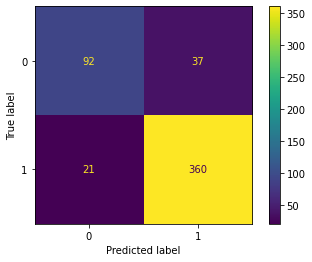

In [52]:
print_all(knn_grid,train_set_no_cat,train_pred_knn,test_set_no_cat,test_pred_knn,roc="None")

## Radius-Neighbors Classifier 

### Grid search

In [53]:
from sklearn.neighbors import RadiusNeighborsClassifier
from scipy.stats import uniform
#radius = np.arange(1.0, 100000.0, 0.1)
radius = uniform(1.0, 10000000.0)
radius_param_grid = {
    'radius': radius,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

### Training

In [54]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=-1, n_iter = 100, cv=8, scoring='accuracy')

radius_grid.fit(train_set_no_cat, train_label)

print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

Accuracy: 0.8382646734637641
Parameters: {'algorithm': 'kd_tree', 'metric': 'euclidean', 'radius': 379521.5218592501, 'weights': 'distance'}


In [55]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set_no_cat, train_label)

In [62]:
train_pred_radius = radius.predict(train_set_no_cat)

In [63]:
test_pred_radius = radius.predict(test_set_no_cat)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       1.00      1.00      1.00       387
   low-level       1.00      1.00      1.00      1140

    accuracy                           1.00      1527
   macro avg       1.00      1.00      1.00      1527
weighted avg       1.00      1.00      1.00      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.86      0.44      0.58       129
   low-level       0.84      0.98      0.90       381

    accuracy                           0.84       510
   macro avg       0.85      0.71      0.74       510
weighted avg       0.84      0.84      0.82       510



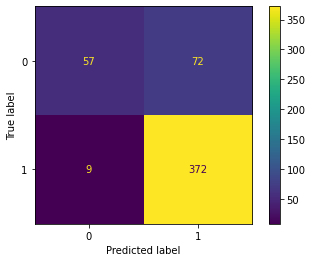

In [64]:
print_all(radius,train_set_no_cat,train_pred_radius,test_set_no_cat,test_pred_radius,roc="None")

## SVM

In [65]:
from sklearn.svm import SVC

In [66]:
svm_param_grid = {
    'C' : [0.5, 2.0],
    'kernel' : ['rbf', 'linear'] 
    }
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, n_jobs=-1, cv=8, scoring=make_scorer(f1_score))

In [67]:
svm_grid.fit(train_set, train_label)

GridSearchCV(cv=8, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.5, 2.0], 'kernel': ['rbf', 'linear']},
             scoring=make_scorer(f1_score))

In [68]:
train_pred_svm = svm_grid.predict(train_set)
test_pred_svm = svm_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.88      0.86      0.87       387
   low-level       0.95      0.96      0.96      1140

    accuracy                           0.94      1527
   macro avg       0.92      0.91      0.91      1527
weighted avg       0.93      0.94      0.93      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.88      0.81      0.84       129
   low-level       0.94      0.96      0.95       381

    accuracy                           0.92       510
   macro avg       0.91      0.88      0.90       510
weighted avg       0.92      0.92      0.92       510



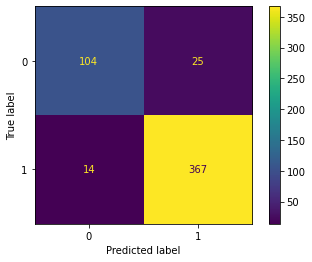

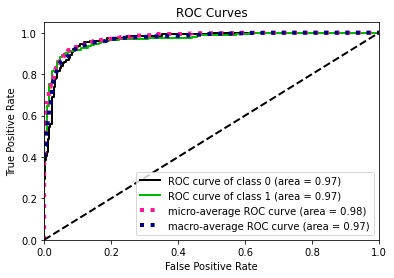

In [69]:
print_all(svm_grid,train_set,train_pred_svm,test_set,test_pred_svm)

## Rule Based Classifier

In [ ]:
import wittgenstein as lw
param_grid = {
    "prune_size": [0.1, 0.2, 0.5, 0.6], 
    "k": [1, 3, 7, 10]
}
rb_grid = GridSearchCV(lw.RIPPER(), param_grid=param_grid, n_jobs=10)

In [ ]:
rb_grid.fit(train_set, train_label)

In [ ]:
rb = rb_grid.best_estimator_
rb.out_model()

In [ ]:
train_pred_rb = rb_grid.predict(train_set)
test_pred_rb = rb_grid.predict(test_set)
print('---TRAIN report:---\n', classification_report(train_label, train_pred_rb, target_names=class_names))
print('---TEST report:---\n',classification_report(test_label, test_pred_rb, target_names=class_names))

### Evaluation

In [ ]:
print_all(rb_grid,train_set,train_pred_rb,test_set,test_pred_rb)

## Random Forest Classifier

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": sp_randint(1, len(train_set.iloc[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, {0: 0.65, 1: 0.35}]}

rf_grid = RandomizedSearchCV(RandomForestClassifier(n_estimators=30), param_distributions=param_dist, 
                            n_iter=50, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))


In [72]:
#run the grid search
rf_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced', None,
                                                         {0: 0.65, 1: 0.35}],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x29b9883d0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x29b981b50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x29b9933d0>},
                   scoring=make_scorer(accuracy_score))

In [73]:
train_pred_rf = rf_grid.predict(train_set)
test_pred_rf = rf_grid.predict(test_set)

### Evaluation

TRAINING:
               precision    recall  f1-score   support

  high-level       0.93      0.86      0.89       387
   low-level       0.95      0.98      0.96      1140

    accuracy                           0.95      1527
   macro avg       0.94      0.92      0.93      1527
weighted avg       0.95      0.95      0.95      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.88      0.78      0.82       129
   low-level       0.93      0.96      0.94       381

    accuracy                           0.92       510
   macro avg       0.90      0.87      0.88       510
weighted avg       0.91      0.92      0.91       510



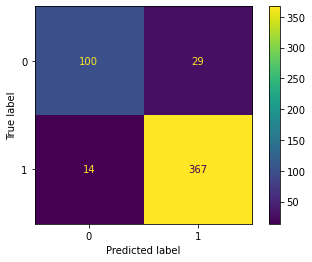

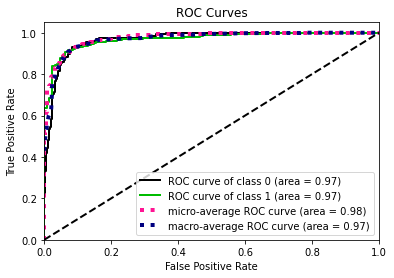

In [74]:
print_all(rf_grid,train_set,train_pred_rf,test_set,test_pred_rf)

## AdaBoosting

In [75]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(train_set, train_label)

AdaBoostClassifier()

In [76]:
test_pred_abc = abc.predict(test_set)
train_pred_abc= abc.predict(train_set)

TRAINING:
               precision    recall  f1-score   support

  high-level       0.92      0.90      0.91       387
   low-level       0.97      0.97      0.97      1140

    accuracy                           0.96      1527
   macro avg       0.95      0.94      0.94      1527
weighted avg       0.96      0.96      0.96      1527

TEST:
               precision    recall  f1-score   support

  high-level       0.86      0.84      0.85       129
   low-level       0.95      0.96      0.95       381

    accuracy                           0.93       510
   macro avg       0.90      0.90      0.90       510
weighted avg       0.92      0.93      0.93       510



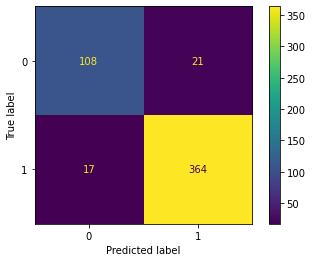

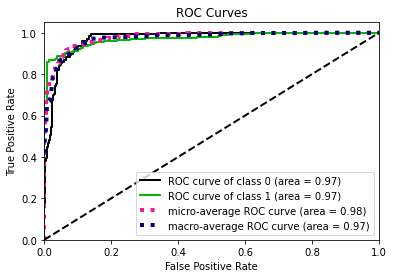

In [77]:
print_all(abc,train_set,train_pred_abc,test_set,test_pred_abc)

## Global models evaluation

Compare results on test set of each model obtained with grid search

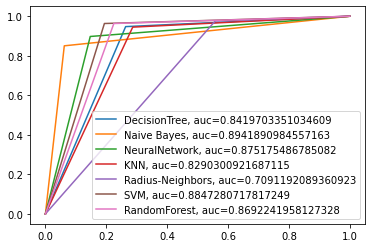

In [78]:
## aggiungi gli altri modelli sotto 

#decision tree 
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_dt)
auc = metrics.roc_auc_score(test_label, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

#bayesian classifier
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_gnb)
auc = metrics.roc_auc_score(test_label, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

#neural network
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_nn)
auc = metrics.roc_auc_score(test_label, test_pred_nn)
plt.plot(fpr,tpr,label="NeuralNetwork, auc="+str(auc))

#KNN
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_knn)
auc = metrics.roc_auc_score(test_label, test_pred_knn)
plt.plot(fpr,tpr,label="KNN, auc="+str(auc))

#Radius-Neighbors
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_radius)
auc = metrics.roc_auc_score(test_label, test_pred_radius)
plt.plot(fpr,tpr,label="Radius-Neighbors, auc="+str(auc))

#SVM
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_svm)
auc = metrics.roc_auc_score(test_label, test_pred_svm)
plt.plot(fpr,tpr,label="SVM, auc="+str(auc))

#Rule Based Classifier
#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rb)
#auc = metrics.roc_auc_score(test_label, test_pred_rb)
#plt.plot(fpr,tpr,label="RuleBasedClassifier, auc="+str(auc))

#RandomForest
fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_rf)
auc = metrics.roc_auc_score(test_label, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

#AdaBoosting
#fpr, tpr, thresh = metrics.roc_curve(test_label, test_pred_abc)
#auc = metrics.roc_auc_score(test_label, test_pred_abc)
#plt.plot(fpr,tpr,label="AdaBoosting, auc="+str(auc))

plt.legend(loc=0)